In [2]:
import SimpleITK as sitk
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import six

import radiomics
from radiomics import firstorder, imageoperations

## Data Setup and Loading

In [3]:
tumor_dir = "../../Data/All_CT/Tumor"
all_tumor_files = os.listdir(tumor_dir)
tumor_files_mhd = [x for x in all_tumor_files if "mhd" in x]
# Remove tumors that don't have corresponding liver image (confirmed externally)
tumor_files_mhd.remove('005_ICCrecurrence_Tumor.mhd')
tumor_files_mhd.remove('057_ICCrecurrence_Tumor.mhd')
tumor_files_mhd.sort()

liver_dir = "../../Data/All_CT/Liver"
all_liver_files = os.listdir(liver_dir)
liver_files_mhd = [y for y in all_liver_files if "mhd" in y]
liver_files_mhd.sort()

print("Tumor file count: ", len(tumor_files_mhd))
print("Liver file count: ", len(liver_files_mhd))

Tumor file count:  441
Liver file count:  441


In [4]:
liver_labels = pd.read_excel("/media/katy/Data/ICC/HDFS/HCC_MCRC_ICC_HDFS_liver_labels.xlsx")

# Dataframe to store features for each patient
liver_features_df = pd.DataFrame(columns=['ScoutID', 'Entropy', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
tumor_features_df = pd.DataFrame(columns=['ScoutID', 'Entropy', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
liver_features_df['ScoutID'] = liver_labels['ScoutID']
tumor_features_df['ScoutID'] = liver_labels['ScoutID']

### Load image and create mask

In [6]:
idx = 12
scoutid = liver_features_df['ScoutID'][idx]
scout_id = scoutid + "_"
print(scout_id)
## DATA LOADING ##

tumor_file = [f for f in tumor_files_mhd if scout_id in f]
liver_file = [f for f in liver_files_mhd if scout_id in f]
if len(tumor_file) != 1:
    print(tumor_file)
    raise Exception("scout_id should find 1 tumor file. Caught %i files.".format(len(tumor_file)))
if len(liver_file) != 1:
    print(liver_file)
    raise Exception("scout_id should find 1 liver file. Caught %i files.".format(len(tumor_file)))

    
# Loading patient idx image
tumor_file = tumor_file[0]
liver_file = liver_file[0]

# print("Tumor file: ", tumor_file)
# print("Liver file: ", liver_file)

# Load tumor image
tumor_img_path = os.path.join(tumor_dir, tumor_file)
tumor_image = sitk.ReadImage(tumor_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)
# Convert to array for mask making
tumor_arr = sitk.GetArrayFromImage(tumor_image)

liver_img_path = os.path.join(liver_dir, liver_file)
liver_mhd_image = sitk.ReadImage(liver_img_path, imageIO="MetaImageIO", outputPixelType=sitk.sitkInt64)
# Convert to array for mask making
liver_arr = sitk.GetArrayFromImage(liver_mhd_image)

013-hcc_


### Mask out tumor from liver image

In [25]:
## MASK MAKING ##
# Make masks for tumor and liver
# -1000 is background value in these images
tumor_mask = tumor_arr != -1000
liver_mask = liver_arr != -1000
# Convert to numeric values for easy handling
tumor_mask = tumor_mask.astype(float)
liver_mask = liver_mask.astype(float)

# Remove tumor from liver image and mask
# Set tumor to 0s in tumor mask and remove from liver mask
notumor_livermask = liver_mask * (1 - tumor_mask)
# Set tumor to 0s in tumor mask, use to set to 0 in liver image, add -1000 to tumor to set as background
notumor_liver = liver_arr * (1 - tumor_mask) + (tumor_mask * -1000)

# plt.imshow(notumor_liver[12,:,:], cmap='gray')

### Confirming data loading and successful tumor masking

In [18]:
np.nonzero(tumor_mask)

(array([19, 19, 19, ..., 34, 34, 34]),
 array([229, 229, 229, ..., 250, 250, 250]),
 array([ 72,  73,  74, ..., 115, 116, 117]))

(37, 512, 512)


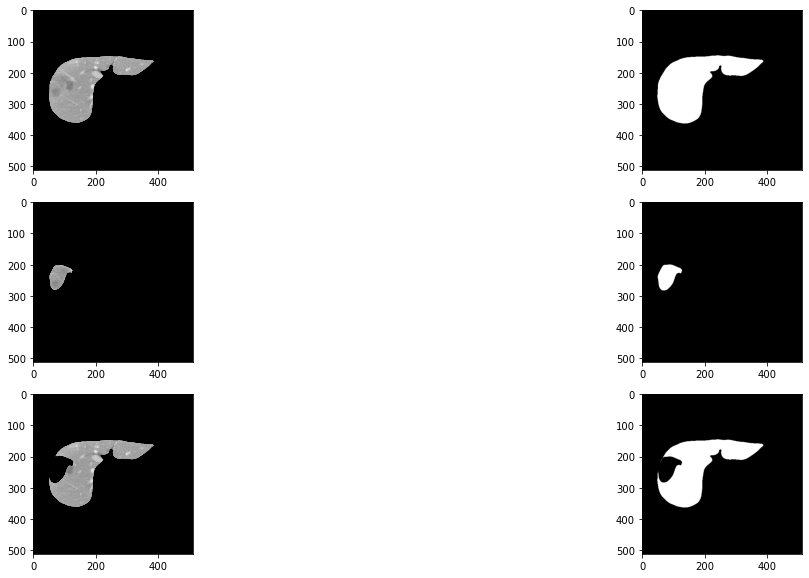

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(20,10))
liverimg_plot = plt.subplot(3, 2, 1)
livermask_plot = plt.subplot(3, 2, 2)
tumorimg_plot = plt.subplot(3, 2, 3)
tumormask_plot = plt.subplot(3, 2, 4)
livernotumor_plot = plt.subplot(3, 2, 5)
livernotumormask_plot = plt.subplot(3, 2, 6)

print(notumor_livermask.shape)
idx = 21
liverimg_plot.imshow(liver_arr[idx,:,:], cmap='gray', vmin=-100, vmax=300)
livermask_plot.imshow(liver_mask[idx,:,:], cmap='gray')
tumorimg_plot.imshow(tumor_arr[idx,:,:], cmap='gray', vmin=-100, vmax=300)
tumormask_plot.imshow(tumor_mask[idx,:,:], cmap='gray')
livernotumor_plot.imshow(notumor_liver[idx,:,:], cmap='gray', vmin=-100, vmax=300)
livernotumormask_plot.imshow(notumor_livermask[idx,:,:], cmap='gray')

In [28]:
# Convert no-tumor liver image and mask back to sitk.Image type for feature extraction
liver_image = sitk.GetImageFromArray(notumor_liver)
liver_mask = sitk.GetImageFromArray(notumor_livermask)
# Set pixels to int type for pyradiomics functions
liver_image = sitk.Cast(liver_image, sitk.sitkInt64)
liver_mask = sitk.Cast(liver_mask, sitk.sitkInt64)

tumor_image = sitk.GetImageFromArray(tumor_arr)
tumor_image = sitk.Cast(tumor_image, sitk.sitkInt64)
tumor_mask = sitk.GetImageFromArray(tumor_mask)
tumor_mask = sitk.Cast(tumor_mask, sitk.sitkInt64)

In [31]:
print(tumor_mask.GetSize())
print(tumor_image.GetSize())

(512, 512, 37)
(512, 512, 37)


# Preprocess the image
Following https://github.com/AIM-Harvard/pyradiomics/blob/master/notebooks/helloFeatureClass.ipynb

#### Extraction settings and resampling

In [32]:
settings = {}
settings['resampledPixelSpacing'] = [1, 1, 1]
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

print("Before resampling: ", liver_image.GetSize())

interpolator = settings.get('interpolator')
# Removes slices with no/few image pixels
resampledPixelSpacing = settings.get('resampledPixelSpacing')
if interpolator is not None and resampledPixelSpacing is not None:
    liver_image, liver_mask = imageoperations.resampleImage(liver_image, liver_mask, **settings)
    tumor_image, tumor_mask = imageoperations.resampleImage(tumor_image, tumor_mask, **settings)


print("After resampling: ", liver_image.GetSize())

Before resampling:  (512, 512, 37)
After resampling:  (351, 223, 35)


## Calculate features using original image


In [10]:
# Crop the image
# bb is bounding box, upon which image and mask are cropped
bb, correctedMask = imageoperations.checkMask(liver_image, liver_mask, label=1)
if correctedMask is not None:
    liver_mask = correctedMask

croppedImage, croppedMask = imageoperations.cropToTumorMask(liver_image, liver_mask, bb)


### Calculate Firstorder features

In [44]:
firstOrderFeatures = firstorder.RadiomicsFirstOrder(croppedImage, croppedMask, **settings)
# firstOrderFeatures.enableAllFeatures()
firstOrderFeatures.enableFeatureByName('Entropy', True)
firstOrderFeatures.enableFeatureByName('Mean', True)
firstOrderFeatures.enableFeatureByName('Variance', True)
firstOrderFeatures.enableFeatureByName('Skewness', True)
firstOrderFeatures.enableFeatureByName('Kurtosis', True)

print("Calculating first order features...")
result = firstOrderFeatures.execute()
print("done")

feats_list = []

print("Calculated first order features: ")
for (key, val) in six.iteritems(result):
    print('    ', key, ':', val)
    feats_list.append(float(val))
    


# Need to take the square root of variance to get standard deviation

Calculating first order features...
done
Calculated first order features: 
     Entropy : 1.5824843222193856
     Mean : 122.19623021596342
     Variance : 329.5935898289986
     Skewness : -1.4349508815305378
     Kurtosis : 16.98905555504112


In [45]:
print(type(key))

<class 'str'>


In [37]:
features_df = pd.DataFrame(columns=['entropy', 'mean', 'variance', 'skewness', 'kurtosis'])
features_df = pd.concat(features_df, )
# features_df

{'Entropy': 1.5824843222193856,
 'Mean': 122.19623021596342,
 'Variance': 329.5935898289986,
 'Skewness': -1.4349508815305378,
 'Kurtosis': 16.98905555504112}

In [ ]:
# Example data used in original tutorial to compare with
# imageName, maskName = radiomics.getTestCase('brain1')

# image = sitk.ReadImage(imageName)
# mask = sitk.ReadImage(maskName)

# image_arr = sitk.GetArrayFromImage(image)
# mask_arr = sitk.GetArrayFromImage(mask)

# print(image.GetSize())
# print(mask.GetSize())
# # plt.imshow(image_arr[15,:,:], cmap='gray')

# image.GetPixelIDTypeAsString()